# Assignment 1: Scraping & Lifts
Members:
*   Chad Graham
*   Jacob Foster
*   Yoav Ilan
*   Enrique Villarreal
*   Martin Dieck







In [ ]:
# Use this code if using Colab to run Selenium

# Make sure to go to Runtime -> Change runtime and set GPU as hardware accelerator

# !kill -9 -1 # Use this line to delete this VM and start a new one.
# The above line deletes all files and folders from the current VM and allocates a new one.

#Selenium is an open-source tool that automates web browsers.
!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
#WebDriver is a browser automation framework that works with open source APIs.
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')

chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

In [ ]:
# create webdriver and point it to the edmunds forum
# we scraped the forum for the 5000 most recent columns
wd = webdriver.Chrome(options=chrome_options)
url = 'https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans/p'
page = 435
wd.get(url+str(page))

In [ ]:
import pandas as pd

# pandas dataframe to hold each comment
comments = pd.DataFrame(columns = ['Date','Comment'])
# limit to 5000 comments
while comments.shape[0] < 5000:
  elements = wd.find_elements(by=By.CLASS_NAME,value="Comment")
  for element in elements:
    date = element.find_element(By.TAG_NAME, "time").text
    comment = element.find_element(By.CLASS_NAME, "userContent")
    # handle a comment that responds to a pervious comment by removing the previous comment
    # this avoids double counting a comment
    try:
      comment_blockquote = comment.find_element(By.TAG_NAME, "blockquote").text
      comments.loc[len(comments.index)] = [date, comment.text.replace(comment_blockquote, '').strip()]
    except:
      comments.loc[len(comments.index)] =[date, comment.text.strip()]
  # iterate to next page
  page -= 1
  wd.get(url+str(page))


In [ ]:
# convert collect dates to datetime objects
comments['Date']= pd.to_datetime(comments['Date'])
# sort comments by date
comments.sort_values(by='Date', inplace=True, ascending=False)
# move date to column since we do not need to work with time series data
comments_nice = comments.set_index('Date')

In [ ]:
# convert new df to csv and export it for exploration
comments_nice.to_csv("results.csv")
!ls
from google.colab import files
files.download("results.csv")

car_models_and_brands.csv  results.csv	sample_data


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# read dataframe in from files after exploration
# this avoids the need to scrape the data every time
import pandas as pd
comments_nice = pd.read_csv('results.csv')
comments_nice[['Comment']] = comments_nice[['Comment']].astype(str)

# Task A

In [ ]:
import re
import numpy as np
# convert comments series where each value is a list of the words in the comment
words_list = comments_nice.Comment.map(lambda x: re.findall('\w+', x.lower()))
words = np.concatenate(words_list)

In [ ]:
# perform count of all words
from collections import Counter
counter = Counter(words)
# convert counter to dataframe for calculations and manipulation
zipfs_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
zipfs_df.rename(columns={'index': 'Word', 0: 'Frequency'}, inplace=True)
zipfs_df.head()

,Word,Frequency
0,explorerx4,1
1,how,672
2,do,996
3,you,3741
4,like,1770


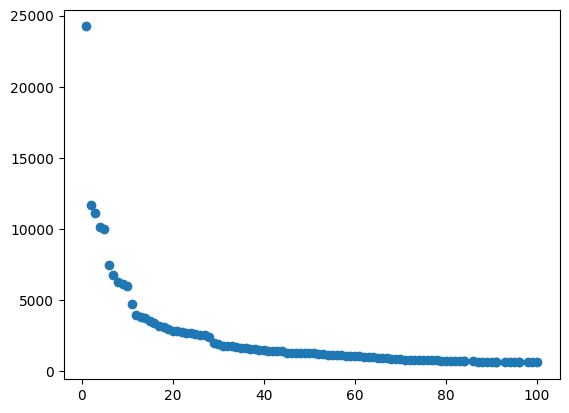

In [ ]:
from scipy.stats import rankdata
import matplotlib.pyplot as plt

# rank the data in descending order, assigning the same value to ties
zipfs_df['Rank'] = rankdata(zipfs_df.Frequency.map(lambda x: 1.0/x), method='min')
# sort data by frequency in a decreasing manner
zipfs_df.sort_values(by='Frequency', ascending=False, inplace=True)

# plot the points
x = zipfs_df.Rank[:100]
y = zipfs_df.Frequency[:100]
plt.scatter(x, y)

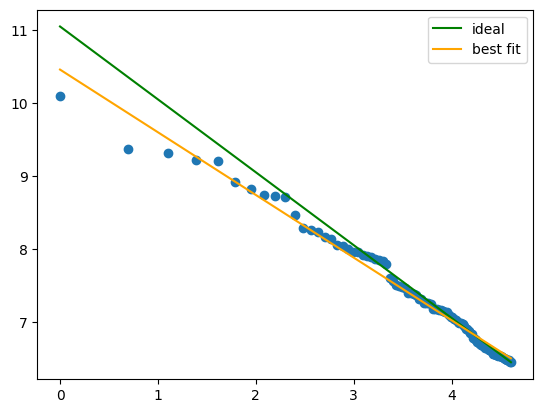

In [ ]:
import math
# convert points to a more linear graph by taking the log of each axis
log_x = x.map(lambda x: math.log(x))
log_y = y.map(lambda y: math.log(y))
# fit a regression to the points
fit = np.polyfit(log_x, log_y, 1)
# plot the points, our regression line, and the ideal regression line (slope=-1)
plt.scatter(log_x, log_y)
plt.plot(log_x, -1*log_x + math.log(zipfs_df.Rank.iloc[100] * zipfs_df.Frequency.iloc[100]), label='ideal', color='green')
plt.plot(log_x, fit[0]*log_x + fit[1], label='best fit', color='orange')
plt.legend(loc='best')
plt.show()

In [ ]:
# TEST IF SLOPE IS STATISTICALLY SIGNIFICANT
import statsmodels.formula.api as smf

last_freq = y.tolist()[99] # 627: fequency of word with 100th rank

values = zipfs_df.copy()

values = pd.DataFrame(columns=["Rank", "Frequency"])
values.Rank = x         # first 100 ranks
values.Frequency = y    # first 100 frequency

values["Term"] = values.Frequency/(100 * last_freq)
values['Ln_Rank'] = np.log(values.Rank)
values["Ln_Term"] = np.log(values.Term)
values["Ln_Frequency"] = np.log(values.Frequency)

results = smf.ols(formula='Ln_Term ~ Ln_Rank',data=values).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                Ln_Term   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     6301.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):           9.50e-91
Time:                        23:13:50   Log-Likelihood:                 89.378
No. Observations:                 100   AIC:                            -174.8
Df Residuals:                      98   BIC:                            -169.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5876      0.041    -14.454      0.0

Since the p-value for the coefficient is less than 0.05, we can conclude that the coefficient is statistically significant when predicting rank. However, Zipf's Law doesn't hold for our data set since -1 is outside the scope of our 95% confidence interval for the coefficient, [-0.881, -0.838].

# Task B

In [ ]:
import string

cars = {}
brands = set()

# read in csv of car makes and models
brands_df = pd.read_csv('car_models_and_brands.csv')
remove_punct = str.maketrans('', '', string.punctuation)

def log_brands(r):
    # remove punctuation errors and create dictionary with model as the key and brand as the value
    cars[r['Model']] = r['Brand'].translate(remove_punct)
    # add each brand to a set for easier access
    brands.add(r['Brand'])

brands_df.apply(log_brands, axis=1)


0      None
1      None
2      None
3      None
4      None
       ... 
515    None
516    None
517    None
518    None
519    None
Length: 520, dtype: object

In [ ]:
# import and download stop words from nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# function to replace model mention in comment with brand name
def model_to_brand(model_make, message):
  for i in range(len(message)):
    if message[i] in model_make:
      message[i] = model_make[message[i]]
  return message

# replace all model mentions with
models_messages = words_list.map(lambda x: model_to_brand(cars, x))

# ensure that each brand is mentioned only once per comment by removing all duplicates words
models_messages_unique = models_messages.map(lambda x: set(x))

In [ ]:
type(models_messages)

In [ ]:
# instantiate counter to track brand mentions through out all comments
word_freqs = Counter()
# count the words and extract the brands from the counts
for s in list(models_messages_unique):
    word_freqs.update(s)
brand_freqs= {}
for brand in brands:
  brand_freqs[brand] = word_freqs[brand]

# convert brands counter/dict to a dataframe
top_brands = pd.DataFrame.from_dict(brand_freqs, orient='index').reset_index()
top_brands.rename(columns={'index': 'Brand', 0: 'Frequency'}, inplace=True)
# take only top 10 brands by count
top_10 = top_brands.sort_values(by='Frequency', ascending=False)[:10]
top_10

,Brand,Frequency
0,bmw,1028
19,audi,841
12,acura,529
24,honda,435
4,volkswagen,263
16,infiniti,239
7,cadillac,221
6,toyota,208
3,hyundai,191
13,ford,167


# Task C

In [ ]:
# convert top 10 brand names to a set for easier access
top_10_brands = set(top_10['Brand'])
top_10_brands

{'acura',
 'audi',
 'bmw',
 'cadillac',
 'ford',
 'honda',
 'hyundai',
 'infiniti',
 'toyota',
 'volkswagen'}

In [ ]:
# instantiate a dataframe for co-occurrences of brand names
df_coc = pd.DataFrame(columns=list(top_10_brands), index=list(top_10_brands))
df_coc.fillna(0, inplace=True)

# copy of df_coc to ensure that an interaction is only counted once per message
df_coc_counts = df_coc.copy()

In [ ]:
# iterate through messages where the models have been replaced with the brands
for message in models_messages:
  # reset the interaction DF to 0 to retrack interactions for each new message
  df_coc_counts.iloc[:] = 0
  for i, word in enumerate(message):
    if word in top_10_brands:
      # if another mention of a brand is within 20 words, count it as an interaction
      for j in range(20):
        # check that the index is still within the length of the message
        if i+j+1 in range(len(message)):
          # check if a different brand is mentioned in the range, not the same brand capture before, and not already logged as an interaction in the interaction dataframe
          if message[i+j+1] in top_10_brands and message[i+j+1] != word and df_coc_counts.loc[word][message[i+j+1]] < 1:
            # update both dfs, counting number of interactions in total, logging an interaction
            df_coc.loc[word][message[i+j+1]] += 1
            df_coc.loc[message[i+j+1]][word] += 1
            df_coc_counts.loc[word][message[i+j+1]] = 1
            df_coc_counts.loc[message[i+j+1]][word] = 1

df_coc

,acura,ford,hyundai,volkswagen,infiniti,bmw,cadillac,toyota,honda,audi
acura,0,5,16,14,73,85,33,14,124,117
ford,5,0,7,13,2,23,7,4,8,12
hyundai,16,7,0,8,6,27,7,17,20,26
volkswagen,14,13,8,0,7,30,5,13,23,90
infiniti,73,2,6,7,0,55,20,6,12,75
bmw,85,23,27,30,55,0,57,21,34,243
cadillac,33,7,7,5,20,57,0,7,7,61
toyota,14,4,17,13,6,21,7,0,48,18
honda,124,8,20,23,12,34,7,48,0,45
audi,117,12,26,90,75,243,61,18,45,0


In [ ]:
# copy over brand co-occurrences dataframe to calculate lifts
lifts = df_coc.copy()

In [ ]:
# calculate lifts
for i in lifts:
  # each i value is one of the top 10 brands
  # find the count for the ith brand in the top10 brands df
  b1_df = top_10[top_10['Brand'] == i]
  # this gets the count using iloc
  b1 = b1_df['Frequency'].iloc[0]
  for j in lifts:
    # get the other count for the jth brand that brand i is co-occurring with
    b2_df = top_10[top_10['Brand'] == j]
    b2 = b2_df['Frequency'].iloc[0]
    # calculating the lift for the i and j brands
    # number of comments: 5033 * co-occurrences of brand i and j OVER
    # product of the count of brands i and j
    lifts.loc[i, j] = (lifts.loc[i, j]*5033)/(b1*b2)

lifts_display = lifts.copy()

for i in range(len(lifts_display.columns)):
  for j in range(i, len(lifts_display)):
    lifts_display.iloc[i, j] = np.nan

lifts_display = lifts_display.T
lifts_display

,acura,ford,hyundai,volkswagen,infiniti,bmw,cadillac,toyota,honda,audi
acura,NaN,0.016229,0.039700,0.018321,0.115683,0.007281,0.061161,0.029292,0.059318,0.014974
ford,NaN,NaN,0.174282,0.170708,0.031802,0.019768,0.130177,0.083976,0.038400,0.015410
hyundai,NaN,NaN,NaN,0.080309,0.072936,0.017740,0.099518,0.272841,0.073390,0.025525
volkswagen,NaN,NaN,NaN,NaN,0.044879,0.010396,0.037491,0.110042,0.044513,0.046601
infiniti,NaN,NaN,NaN,NaN,NaN,0.023080,0.181595,0.061501,0.028123,0.047025
bmw,NaN,NaN,NaN,NaN,NaN,NaN,0.027974,0.011635,0.004307,0.008235
cadillac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.083915,0.019186,0.044731
toyota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.148522,0.014901
honda,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.008517
audi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
''' To get the best results for mapping the brands relationship using MDS,
    we found that 3-x allowed for a more accurate display of brand relationships
    than 1/x. To determine that 3 was the most appropriate value, we found the
    maximum value (~2.9) in the entire lifts dataframe, rounded it to the next
    highest integer (3) and subtracted all values from that integer. Thus, we
    are left with the dissimilarity matrix below.
'''
dissim = lifts.applymap(lambda x: 0 if x==0 else 3-x)
dissim

,acura,ford,hyundai,volkswagen,infiniti,bmw,cadillac,toyota,honda,audi
acura,0.000000,2.715144,2.203001,2.493542,0.093996,2.213322,1.579331,2.359623,0.287913,1.676387
ford,2.715144,0.000000,1.895476,1.510303,2.747801,2.325712,2.045411,2.420428,2.445743,2.569973
hyundai,2.203001,1.895476,0.000000,2.198455,2.338474,2.307907,2.165360,0.846330,1.788470,2.185350
volkswagen,2.493542,1.510303,2.198455,0.000000,2.439506,2.441531,2.567039,1.803945,1.988165,0.952058
infiniti,0.093996,2.747801,2.338474,2.439506,0.000000,1.873325,1.094246,2.392541,2.419074,1.122006
bmw,2.213322,2.325712,2.307907,2.441531,1.873325,0.000000,1.737253,2.505701,2.617331,1.585366
cadillac,1.579331,2.045411,2.165360,2.567039,1.094246,1.737253,0.000000,2.233576,2.633526,1.348158
toyota,2.359623,2.420428,0.846330,1.803945,2.392541,2.505701,2.233576,0.000000,0.329973,2.482107
honda,0.287913,2.445743,1.788470,1.988165,2.419074,2.617331,2.633526,0.329973,0.000000,2.380909
audi,1.676387,2.569973,2.185350,0.952058,1.122006,1.585366,1.348158,2.482107,2.380909,0.000000


# Task D

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


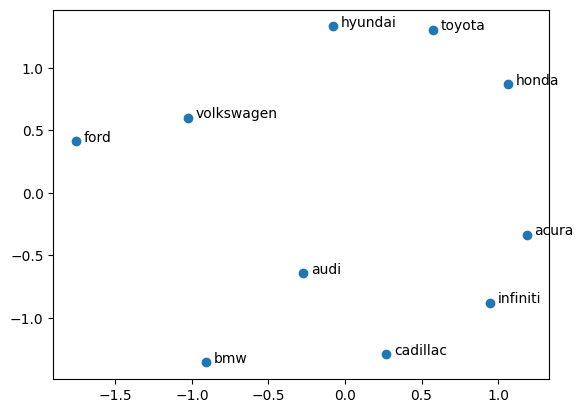

In [ ]:
from sklearn.manifold import MDS

# create MDS from our precomputed dissimilarity matrix
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
scaled_coc = mds.fit_transform(dissim)

# plot the MDS with labels
plt.scatter(scaled_coc[:,0], scaled_coc[:,1])
for i, txt in enumerate(df_coc.index):
  plt.annotate(txt, (scaled_coc[:,0][i]+0.05, scaled_coc[:,1][i]))

plt.show()

# Task E

There are a few takeaways JD Power should be aware of. Based on our calculations, there are certain brands that are highly synonymous with others. Plotting those brand-to-brand associations, we can start seeing clusters forming. In cluster One, we have our budget champions Hyundai, Toyota, and Honda. In Cluster Two, we have the perceived luxury cars that try to provide either extra performance or luxury in Acura, Audi, Infiniti, Cadillac, and BMW. Finally, we have Ford and Volkswagen that did not neatly fit in either of the two primary clusters, but have some association between themselves.

Of the brand-to-brand pairs, we noticed that Acura and Infiniti are the two most highly correlated brands in terms of co-occurrences. It's important to note that talking about one will not cause someone to talk about the other, instead meaning that there's simply a tendency to talk about both at the same time.

# Task F

In [ ]:
# get word frequencies from the existing word freq dict created in Task B
word_freqs_df = pd.DataFrame.from_dict(word_freqs, orient='index')
# remove stopwords to allow for easier exploration
word_freqs_df = word_freqs_df.loc[~word_freqs_df.index.isin(stopwords)]
# convert df to csv and export it for exploration
word_freqs_df.to_csv('word_freqs.csv')
from google.colab import files
files.download("word_freqs.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# taken by taking some of the top attributes found in word frequency
attributes = set(['price', 'miles', 'sport', 'luxury', 'performance'])

In [ ]:
# create a df that holds the co-occurrences between brands and attributes
df_attr_coc = pd.DataFrame(columns=list(top_10_brands), index=list(attributes))
df_attr_coc.fillna(0, inplace=True)

# copy of df_coc to ensure that an interaction is only counted once per message
df_attr_coc_counts = df_attr_coc.copy()
df_attr_coc_counts

,acura,ford,hyundai,volkswagen,infiniti,bmw,cadillac,toyota,honda,audi
price,0,0,0,0,0,0,0,0,0,0
luxury,0,0,0,0,0,0,0,0,0,0
performance,0,0,0,0,0,0,0,0,0,0
sport,0,0,0,0,0,0,0,0,0,0
miles,0,0,0,0,0,0,0,0,0,0


In [ ]:
# iterate through messages where the models have been replaced with the brands
for message in models_messages:
  # reset the interaction DF to 0 to retrack interactions for each new message
  df_attr_coc_counts.iloc[:] = 0
  for i, word in enumerate(message):
    # check top 10 brands and the next 15 words for attributes
    if word in top_10_brands:
      # if another mention of an attribute is within 15 words, count it as an interaction
      for j in range(15):
        # check that the index is still within the length of the message
        if i+j+1 in range(len(message)):
          # check if an attribute is mentioned in the range, not the same brand capture before, and not already logged as an interaction in the interaction dataframe
          if message[i+j+1] in attributes and df_attr_coc_counts.loc[message[i+j+1]][word] < 1:
            # update both dfs, counting number of interactions in total, logging an interaction
            df_attr_coc.loc[message[i+j+1]][word] += 1
            df_attr_coc_counts.loc[message[i+j+1]][word] = 1

    # check attributes and the next 15 words for brands
    elif word in attributes:
      # if another mention of a brand is within 15 words, count it as an interaction
      for j in range(15):
        # check that the index is still within the length of the message
        if i+j+1 in range(len(message)):
          # check if a different brand is mentioned in the range, not the same brand capture before, and not already logged as an interaction in the interaction dataframe
          if message[i+j+1] in top_10_brands and df_attr_coc_counts.loc[word][message[i+j+1]] < 1:
            # update both dfs, counting number of interactions in total, logging an interaction
            df_attr_coc.loc[word][message[i+j+1]] += 1
            df_attr_coc_counts.loc[word][message[i+j+1]] = 1


df_attr_coc

,acura,ford,hyundai,volkswagen,infiniti,bmw,cadillac,toyota,honda,audi
price,23,10,14,7,6,64,12,6,12,55
luxury,32,4,16,6,9,39,20,5,16,35
performance,22,8,1,8,6,38,6,10,10,34
sport,18,1,8,3,6,85,2,16,18,54
miles,19,2,3,6,3,23,4,8,20,36


In [ ]:
# isolate the count for each attribtue
attr_freqs_df = word_freqs_df[word_freqs_df.index.isin(attributes)].reset_index()
attr_freqs_df.rename(columns={'index': 'Attribute', 0: 'Frequency'}, inplace=True)
attr_freqs_df

,Attribute,Frequency
0,luxury,284
1,miles,357
2,performance,313
3,price,446
4,sport,337


In [ ]:
# calculate the lifts between attributes and the top 10 brands
attr_lifts = df_attr_coc.copy()

# iterate through df rows and columns
for i, row in attr_lifts.iterrows():
  for j in attr_lifts.columns:
    # get number of co-occurrences from the df_attr_coc dataframe
    coc = attr_lifts.loc[i, j]

    # get the count of each attribute i from the attribute frequency dataframe
    attr_count = attr_freqs_df[attr_freqs_df.Attribute == i]['Frequency'].iloc[0]
    # get the brand count from the top 10 brand count dataframe from before
    brand_count = top_10[top_10.Brand == j]['Frequency'].iloc[0]

    # lift formula
    attr_lifts.loc[i, j] = (5033*coc) / (attr_count * brand_count)

attr_lifts

,acura,ford,hyundai,volkswagen,infiniti,bmw,cadillac,toyota,honda,audi
price,0.490641,0.675734,0.827155,0.300355,0.283299,0.702553,0.612747,0.325522,0.311304,0.738004
luxury,1.072020,0.424475,1.484551,0.404300,0.667349,0.672326,1.603786,0.426006,0.651837,0.737532
performance,0.668728,0.770293,0.084188,0.489122,0.403679,0.594392,0.436558,0.773071,0.369652,0.650078
sport,0.508176,0.089429,0.625538,0.170358,0.374930,1.234875,0.135156,1.148824,0.617988,0.958947
miles,0.506357,0.168839,0.221435,0.321628,0.176963,0.315423,0.255168,0.542232,0.648186,0.603483


# Task G

We have a few brand-to-attribute pairings to know. The strongest of these is Cadillac - Luxury, followed closely by Hyundai - luxury. It's curious that these two brands were the top two in this category, and we'd certainly need to do a deeper dive to understand the type of relationship between those brands and the luxury attribute. Assuming all co-occurrences are positive, though, we can conclude that Hyundais punch above their weight in this category, especially when the other brands in its cluster are nowhere near.

Many of our brand-attribute values are insignficant. To improve our outputs, we will need to collect much more data and implement the idea of attention to pick up associations that don't list the brand or attribute exactly.

# Task H

In [ ]:
# aspirational words related to brands
aspirations = ['love to', 'dream to', 'hope', 'aspire', 'imagine', 'innovative', 'excited', 'ideal', 'prestige', 'dream of', 'inspire']

# find words from the aspirations array to replace with 'aspirational' for each comment
def replace_asp(s):
  s = ' '.join(s)
  for a in aspirations:
    s = s.replace(a, 'aspirational')
  return s.split()

# create new series where each value is a list of words, but the aspirational words/phrases
# have been replaced with the word 'aspirational'
asp_series = models_messages.map(replace_asp)

# init aspirational dataframe to track co-occurrences between brands and aspirational phrases
asp_df = pd.DataFrame(columns=list(top_10_brands), index=['aspirational'])
asp_df.fillna(0, inplace=True)

# copy of df_coc to ensure that an interaction is only counted once per message
asp_df_counts = asp_df.copy()

# iterate through messages where the models have been replaced with the brands
for message in asp_series:
  # reset the interaction DF to 0 to retrack interactions for each new message
  asp_df_counts.iloc[:] = 0
  for i, word in enumerate(message):
    # check top 10 brands and the next 15 words for aspirational
    if word in top_10_brands:
      # if another mention of an attribute is within 15 words, count it as an interaction
      for j in range(15):
        # check that the index is still within the length of the message
        if i+j+1 in range(len(message)):
          # check if an aspirational is mentioned in the range, not the same brand capture before, and not already logged as an interaction in the interaction dataframe
          if message[i+j+1] == 'aspirational' and asp_df_counts.loc['aspirational'][word] < 1:
            # update both dfs, counting number of interactions in total, logging an interaction
            asp_df.loc['aspirational'][word] += 1
            asp_df_counts.loc['aspirational'][word] = 1

    # check aspirational and the next 15 words for brands
    elif word == 'aspirational':
      # if another mention of a brand is within 15 words, count it as an interaction
      for j in range(15):
        # check that the index is still within the length of the message
        if i+j+1 in range(len(message)):
          # check if a different brand is mentioned in the range, not the same brand capture before, and not already logged as an interaction in the interaction dataframe
          if message[i+j+1] in top_10_brands and asp_df_counts.loc[word][message[i+j+1]] < 1:
            # update both dfs, counting number of interactions in total, logging an interaction
            asp_df.loc[word][message[i+j+1]] += 1
            asp_df_counts.loc[word][message[i+j+1]] = 1

In [ ]:
# count number of aspriational comment occurrences for lift
asp_series_unique = asp_series.map(lambda x: set(x))

asp_count = 0
for s in list(asp_series_unique):
  if 'aspirational' in s:
    asp_count += 1

asp_count

268

In [ ]:
# data frame to calculate lifts between brands and aspirational words
asp_lifts = asp_df.copy()

for brand in asp_lifts.columns:
  # get number of co-occurreneces
  coc = asp_lifts.loc['aspirational', brand]
  # get brand count
  brand_count = top_10[top_10.Brand == brand]['Frequency'].iloc[0]
  # calculate lift
  asp_lifts.loc['aspirational', brand] = (5033*coc) / (asp_count * brand_count)

# display count of co-occurrences and the lift between brands and aspirational
print(asp_lifts.T.sort_values(by='aspirational', ascending=False))
asp_df.T.sort_values(by="aspirational", ascending=False)

            aspirational
audi            1.094189
cadillac        0.849767
acura           0.745514
bmw             0.529782
infiniti        0.314307
toyota          0.270863
ford            0.224908
hyundai         0.196648
volkswagen      0.142813
honda           0.129516


,aspirational
audi,49
bmw,29
acura,21
cadillac,10
infiniti,4
toyota,3
honda,3
ford,2
hyundai,2
volkswagen,2


Our analysis was done by creating a list of aspirational words and phrases to look for. We used the following list:
- love to
- dream to
- hope
- aspire
- imagine
- innovative
- excited
- ideal
- prestige
- dream of
- inspire

Once we found any of these words/phrases, we replaced them with the word "aspirational." Once that was done, we found co-occurrences of "aspirational" with our top brands. Our results show that Audi was by far the most aspirational of the top brands. However, that by no means says that Audi is an aspirational brand, as the actual calculated value between "aspirational" and Audi was just above 1, meaning it was barely positive.

To improve on these results, we can use a few tactics:
1. add more aspirational words/phrases to try to find more co-occurrences
2. implement attention to find co-occurrences where the brand is not named explicitly
3. add more brands to our analyses, especially high-end models (i.e. Ferrari, McLaren, etc.) to see whether aspirations are more synonymous with these extremely prestigious brands.

